In [1]:
# import des librairies
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import pickle

# clean text data
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# # prep the data for the model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

2023-08-11 15:45:13.075261: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-11 15:45:13.454153: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-11 15:45:13.455922: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-11 15:45:15.147922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# import des données
jobs_df = pd.read_csv("../data/silver/silver_data.csv")
jobs_salary = pd.read_csv("../data/job_salary.csv")
company_salary = pd.read_csv("../data/company_salary.csv")
jobs_df.head()

,jobs,description,loc,datePosted,workhours,salary,contract_type,experience,diploma,skills,qualifications,industry,company,size,company_description,tools,ID_dep,ville,date
0,Data Engineer sénior (F/H) CDI (H/F),"En tant que Data Engineer chez Quantmetry, vou...",75 - PARIS 08,Actualisé le 12 juillet 2023,38H Travail en journée,40000.0 - 50000.0,Contrat à durée indéterminée,5 ans,NaN,"['Concevoir et gérer un projet', ""Concevoir un...",Cadre,Conseil pour les affaires et autres conseils d...,QUANTMETRY,100 à 199 salariés,Pure player en Data et Intelligence Artificiel...,NaN,75,PARIS 08,2023/07/12
1,Data Consultant Stratégie Sénior (H/F),Nous recrutons des personnes avec une appétenc...,75 - PARIS 08,Actualisé le 12 juillet 2023,35H Travail en journée,3100.0 - 5000.0,Contrat à durée indéterminée,5 ans,NaN,"[""Analyser les résultats d'un projet"", ""Déclin...",Cadre,Conseil pour les affaires et autres conseils d...,QUANTMETRY,100 à 199 salariés,Pure player en Data et Intelligence Artificiel...,NaN,75,PARIS 08,2023/07/12
2,Chef de projets Performance Durable/Energie/Da...,Intégré(e) au sein de la Direction Performance...,92 - ASNIERES SUR SEINE,Actualisé le 13 juillet 2023,35H Travail en journée,NaN,Contrat à durée indéterminée,3 ans,NaN,['Contrôler et faire appliquer le respect de d...,Employé qualifié,Activités des sièges sociaux,NEXITY,250 à 499 salariés,Nexity est aujourd hui leader sur les différen...,tableau,92,ASNIERES SUR SEINE,2023/07/13
3,Ingénieur Data H/F,"Vos missions\nAu sein de projets Agile Scrum, ...",66 - PERPIGNAN,Actualisé le 19 juillet 2023,35H Travail en journée,NaN,Contrat à durée indéterminée,5 ans,NaN,"['Concevoir et gérer un projet', ""Concevoir un...",Cadre,"Autres intermédiaires du commerce en denrées, ...",SOCIETE DE DISTRIBUTION DE PRODUITS MARA,100 à 199 salariés,"Azura, est un groupe familial, en forte croiss...","tableau, sas",66,PERPIGNAN,2023/07/19
4,Data Engineer pour la Qualité Totale H/F (H/F),Vous êtes Rattaché(e) au Responsable de l'équi...,92 - ST CLOUD,Actualisé le 19 juillet 2023,35H Travail en journée,38000.0 - 70000.0,Contrat à durée indéterminée,5 ans,NaN,"['Application web', 'Déterminer des mesures co...",Cadre,Activités des sièges sociaux,DASSAULT AVIATION,Non employeur (pas de salarié au cours de l'an...,Dassault Aviation,NaN,92,ST CLOUD,2023/07/19


In [3]:
jobs_df.shape

(1901, 19)

In [4]:
jobs_salary.head()

,Job,salary($),salary_type,Base Salary,Bonus,Total Pay,Profit Sharing,Commission,Hourly Rate
0,ABAP Developer,90000.0,year,$68k - $120k,$2k - $20k,$67k - $132k,NaN,NaN,NaN
1,ASIC Design Engineer,108330.0,year,$83k - $148k,$1k - $15k,$85k - $164k,$2k - $15k,NaN,NaN
2,ASIC Engineer,116546.0,year,$59k - $165k,$503 - $22k,$59k - $179k,NaN,NaN,NaN
3,ASP.NET Developer,71152.0,year,$50k - $94k,$993 - $10k,$47k - $96k,$2k - $5k,NaN,NaN
4,Actuarial Associate,82113.0,year,$65k - $101k,$2k - $13k,$67k - $109k,$2k - $7k,NaN,NaN


In [5]:
company_salary.head()

,company,avg_salary($),salary_type
0,A.B._Data%2C_Ltd.,NaN,year
1,A-Tech,20.0,hour
2,A_Wireless,NaN,year
3,A_%26_A_Telecom,83.0,year
4,A_%26_T_Systems,NaN,year


## Nettoyage et préparation des données

In [6]:
# préparer un df avec uniquement les colonnes à utiliser pour le modèle
df = jobs_df[["jobs", "description", "ID_dep", "ville", "date", "experience", "skills", "tools", "industry", "company", "company_description"]]
df.head()

,jobs,description,ID_dep,ville,date,experience,skills,tools,industry,company,company_description
0,Data Engineer sénior (F/H) CDI (H/F),"En tant que Data Engineer chez Quantmetry, vou...",75,PARIS 08,2023/07/12,5 ans,"['Concevoir et gérer un projet', ""Concevoir un...",NaN,Conseil pour les affaires et autres conseils d...,QUANTMETRY,Pure player en Data et Intelligence Artificiel...
1,Data Consultant Stratégie Sénior (H/F),Nous recrutons des personnes avec une appétenc...,75,PARIS 08,2023/07/12,5 ans,"[""Analyser les résultats d'un projet"", ""Déclin...",NaN,Conseil pour les affaires et autres conseils d...,QUANTMETRY,Pure player en Data et Intelligence Artificiel...
2,Chef de projets Performance Durable/Energie/Da...,Intégré(e) au sein de la Direction Performance...,92,ASNIERES SUR SEINE,2023/07/13,3 ans,['Contrôler et faire appliquer le respect de d...,tableau,Activités des sièges sociaux,NEXITY,Nexity est aujourd hui leader sur les différen...
3,Ingénieur Data H/F,"Vos missions\nAu sein de projets Agile Scrum, ...",66,PERPIGNAN,2023/07/19,5 ans,"['Concevoir et gérer un projet', ""Concevoir un...","tableau, sas","Autres intermédiaires du commerce en denrées, ...",SOCIETE DE DISTRIBUTION DE PRODUITS MARA,"Azura, est un groupe familial, en forte croiss..."
4,Data Engineer pour la Qualité Totale H/F (H/F),Vous êtes Rattaché(e) au Responsable de l'équi...,92,ST CLOUD,2023/07/19,5 ans,"['Application web', 'Déterminer des mesures co...",NaN,Activités des sièges sociaux,DASSAULT AVIATION,Dassault Aviation


In [7]:
df["jobs"] = df["jobs"].str.replace(" h/f", "")
df["jobs"] = df["jobs"].str.replace("\s*\([hH]/[fF]\)\s*", " ").str.strip()
df["jobs"] = df["jobs"].str.replace(" (H/F)", "")
df["jobs"] = df["jobs"].str.replace(" H/F", "")
df["jobs"] = df["jobs"].str.replace(" F/H", "")
df["jobs"] = df["jobs"].str.replace(" (F/H)", "")
df["jobs"] = df["jobs"].str.replace(" \(\)", "")

/tmp/ipykernel_15741/3925056316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["jobs"] = df["jobs"].str.replace(" h/f", "")
/tmp/ipykernel_15741/3925056316.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["jobs"] = df["jobs"].str.replace("\s*\([hH]/[fF]\)\s*", " ").str.strip()
/tmp/ipykernel_15741/3925056316.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

In [8]:
df.dtypes

jobs                   object
description            object
ID_dep                 object
ville                  object
date                   object
experience             object
skills                 object
tools                  object
industry               object
company                object
company_description    object
dtype: object

In [9]:
# Prétraitement des données
def preprocess_text(text):
    # Suppression des caractères spéciaux et de la ponctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Conversion en minuscules
    text = text.lower()
    
    # Suppression des mots vides
    stop_words = set(stopwords.words('french'))  
    tokens = text.split()
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatisation
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    # Rejoindre les tokens prétraités en une seule chaîne
    processed_text = ' '.join(tokens)
    
    return processed_text

In [10]:
df["description"][0]

"En tant que Data Engineer chez Quantmetry, vous serez amené à travailler sur des problématiques de :  \n\nIngestion de données (collecte push/pull stream, batch), règles de qualité, traçabilité, conformité et confidentialié. \n\nMise en œuvre de pipeline de données permettant de gérer les normalisations, enrichissements, mise en qualité, calculs de KPI   \n\nMise en œuvre d'outils de stockage appropriés (base de données SQL, No-SQL, stockage fichier ou objets) en fonction de la performance ou du coût \n\nModélisation des données, dès la collecte jusqu'à l'exposition \n\nTraiter, modéliser, stocker, interroger et visualiser les données pour les fournir à des utilisateurs métiers \n\nConception et développement d'APIs pour rendre disponible les données  \n\nMettre en place et configurer les services de monitoring techniques, applicatifs et flux \n\nMettre en place et utiliser les outils d'orchestrations et de CI/CD  \n\nParticiper à l'industrialisation et l'optimisation d'algorithmes de

In [11]:
df["description"] = df["description"].apply(preprocess_text)
df["company_description"] = df["company_description"].astype(str)
df["company_description"] = df["company_description"].apply(preprocess_text)
df["experience"] = df["experience"].apply(preprocess_text)

/tmp/ipykernel_15741/3973741798.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["description"] = df["description"].apply(preprocess_text)
/tmp/ipykernel_15741/3973741798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["company_description"] = df["company_description"].astype(str)
/tmp/ipykernel_15741/3973741798.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [12]:
df["experience"][1]

'5 an'

In [13]:
df.head()

,jobs,description,ID_dep,ville,date,experience,skills,tools,industry,company,company_description
0,Data Engineer sénior CDI,tant data engineer chez quantmetry amené trava...,75,PARIS 08,2023/07/12,5 an,"['Concevoir et gérer un projet', ""Concevoir un...",NaN,Conseil pour les affaires et autres conseils d...,QUANTMETRY,pure player data intelligence artificielle qua...
1,Data Consultant Stratégie Sénior,recrutons personnes appétence forte data lia c...,75,PARIS 08,2023/07/12,5 an,"[""Analyser les résultats d'un projet"", ""Déclin...",NaN,Conseil pour les affaires et autres conseils d...,QUANTMETRY,pure player data intelligence artificielle qua...
2,Chef de projets Performance Durable/Energie/Da...,intégrée sein direction performance durable ne...,92,ASNIERES SUR SEINE,2023/07/13,3 an,['Contrôler et faire appliquer le respect de d...,tableau,Activités des sièges sociaux,NEXITY,nexity aujourd hui leader différents métiers i...
3,Ingénieur Data,mission sein projets agile scrum mission défin...,66,PERPIGNAN,2023/07/19,5 an,"['Concevoir et gérer un projet', ""Concevoir un...","tableau, sas","Autres intermédiaires du commerce en denrées, ...",SOCIETE DE DISTRIBUTION DE PRODUITS MARA,azura groupe familial forte croissance spécial...
4,Data Engineer pour la Qualité Totale,rattachée responsable léquipe méthodes support...,92,ST CLOUD,2023/07/19,5 an,"['Application web', 'Déterminer des mesures co...",NaN,Activités des sièges sociaux,DASSAULT AVIATION,dassault aviation


In [14]:
df.shape

(1901, 11)

In [15]:
df.isnull().sum()

jobs                      0
description               0
ID_dep                    0
ville                   228
date                      0
experience                0
skills                  861
tools                   930
industry               1031
company                 965
company_description       0
dtype: int64

In [16]:
df.dtypes

jobs                   object
description            object
ID_dep                 object
ville                  object
date                   object
experience             object
skills                 object
tools                  object
industry               object
company                object
company_description    object
dtype: object

In [17]:
df.fillna("aucune valeur", inplace=True)

/tmp/ipykernel_15741/2316103424.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna("aucune valeur", inplace=True)


In [18]:
df['company_description'] = df['company_description'].replace('nan', 'aucune description')

/tmp/ipykernel_15741/3294830435.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['company_description'] = df['company_description'].replace('nan', 'aucune description')


In [19]:
df.head()

,jobs,description,ID_dep,ville,date,experience,skills,tools,industry,company,company_description
0,Data Engineer sénior CDI,tant data engineer chez quantmetry amené trava...,75,PARIS 08,2023/07/12,5 an,"['Concevoir et gérer un projet', ""Concevoir un...",aucune valeur,Conseil pour les affaires et autres conseils d...,QUANTMETRY,pure player data intelligence artificielle qua...
1,Data Consultant Stratégie Sénior,recrutons personnes appétence forte data lia c...,75,PARIS 08,2023/07/12,5 an,"[""Analyser les résultats d'un projet"", ""Déclin...",aucune valeur,Conseil pour les affaires et autres conseils d...,QUANTMETRY,pure player data intelligence artificielle qua...
2,Chef de projets Performance Durable/Energie/Da...,intégrée sein direction performance durable ne...,92,ASNIERES SUR SEINE,2023/07/13,3 an,['Contrôler et faire appliquer le respect de d...,tableau,Activités des sièges sociaux,NEXITY,nexity aujourd hui leader différents métiers i...
3,Ingénieur Data,mission sein projets agile scrum mission défin...,66,PERPIGNAN,2023/07/19,5 an,"['Concevoir et gérer un projet', ""Concevoir un...","tableau, sas","Autres intermédiaires du commerce en denrées, ...",SOCIETE DE DISTRIBUTION DE PRODUITS MARA,azura groupe familial forte croissance spécial...
4,Data Engineer pour la Qualité Totale,rattachée responsable léquipe méthodes support...,92,ST CLOUD,2023/07/19,5 an,"['Application web', 'Déterminer des mesures co...",aucune valeur,Activités des sièges sociaux,DASSAULT AVIATION,dassault aviation


## Baseline Model

In [20]:
tools = df["tools"].values
job_description = df["description"].values
job_title = df["jobs"].values
# Enlever les espaces vides à la fin
job_title = np.array([title.rstrip() for title in job_title])

In [21]:
def create_text_sequences(tools_data, description_data, target_data, sequence_length):
    """
    Créer des séquences pour la génération de texte.
    
    Arguments:
    - tools_data : Liste de tokens représentant les outils.
    - description_data : Liste de tokens représentant les descriptions de job.
    - sequence_length : La longueur souhaitée pour chaque séquence.
    - target_data : Liste de tokens représentant les titres de job à prédire.
    - target_length : La longueur souhaitée pour chaque séquence cible.
    
    Retour:
    - inputs: Une liste de listes où chaque sous-liste contient une séquence d'outils et une séquence de descriptions.
    - targets: Une liste contenant les séquences cibles.
    """
    
    # Vérification de la cohérence des longueurs
    if len(tools_data) != len(description_data) or len(tools_data) != len(target_data):
        raise ValueError("Les listes tools_data, description_data, et target_data doivent avoir la même longueur.")
    
    inputs = []
    decoder_inputs = []
    targets = []
    
    # Calcul du pas pour la fenêtre glissante
    step = sequence_length
    
    for i in range(0, len(tools_data), step):
        end_idx = i + sequence_length

        if end_idx <= len(tools_data):
            tools_sequence = tools_data[i:end_idx]
            description_sequence = description_data[i:end_idx]
            target_sequence = target_data[i:end_idx]

            inputs.append(tools_sequence)
            decoder_inputs.append(description_sequence)
            targets.append(target_sequence)
        
    return inputs, decoder_inputs, targets

In [22]:
length_seq = 1
# Utilisation
input_sequence, decoder_input_sequence, target_sequence = create_text_sequences(tools, job_description, job_title, length_seq)
print("input_sequence length", len(input_sequence))
print("decoder_input_sequence length", len(decoder_input_sequence))
print("target_sequence length", len(target_sequence))

input_sequence length 1901
decoder_input_sequence length 1901
target_sequence length 1901


In [23]:
from sklearn.model_selection import train_test_split

# instance the tokenizer
tokenizer = Tokenizer()

# Convert sequences into text format for Tokenizer
input_texts = [" ".join(map(str, seq)) for seq in input_sequence]
target_texts = ["<start> " + " ".join(map(str, seq)) + " <end>" for seq in target_sequence]

# Fit Tokenizer on data
tokenizer.fit_on_texts(input_texts + target_texts)
tokenizer.word_index['<start>'] = len(tokenizer.word_index) + 1
tokenizer.word_index['<end>'] = len(tokenizer.word_index) + 1

# Convert sequences to tokenized sequences
input_sequences = tokenizer.texts_to_sequences(input_texts)
target_sequences = tokenizer.texts_to_sequences(target_texts)

# Find maximum lengths
max_sequence_length = max([len(seq) for seq in input_sequences + target_sequences])

# Pad sequences
input_sequences = pad_sequences(input_sequences, maxlen=max_sequence_length, padding='post')
target_sequences = pad_sequences(target_sequences, maxlen=max_sequence_length, padding='post')

# Get the vocabulary size
vocab_size = len(tokenizer.word_index) + 1

In [25]:
# Define the input layers
encoder_inputs = Input(shape=(max_sequence_length,))
decoder_inputs = Input(shape=(max_sequence_length-1,))

# Define model architecture
latent_dim = 50 # Dimensionality of the latent space
embedding = Embedding(vocab_size, latent_dim)

encoder_embedding = embedding(encoder_inputs)
encoder_lstm = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

decoder_embedding = embedding(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Create the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Compile the model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

assert len(input_sequence) == len(target_sequence), "Mismatched sequence lengths!"

# Jusqu'ici, tout est identique. Maintenant, divisons les données:
input_train, input_val, target_train, target_val = train_test_split(input_sequences, target_sequences, test_size=0.2, random_state=42)

# Préparez les séquences d'entraînement et de validation :
target_train_input = target_train[:, :-1]
target_train_output = target_train[:, 1:]
target_train_output = np.expand_dims(target_train_output, -1)

target_val_input = target_val[:, :-1]
target_val_output = target_val[:, 1:]
target_val_output = np.expand_dims(target_val_output, -1)

# Train the model
baseline = model.fit([input_train, target_train_input], 
                     target_train_output,
                     validation_data=([input_val, target_val_input], target_val_output),
                     epochs=100, 
                     batch_size=8)

Epoch 1/100
190/190 [==============================] - 8s 25ms/step - loss: 2.3655 - val_loss: 1.3539
Epoch 2/100
190/190 [==============================] - 4s 20ms/step - loss: 1.2177 - val_loss: 1.1672
Epoch 3/100
190/190 [==============================] - 4s 19ms/step - loss: 1.1192 - val_loss: 1.1052
Epoch 4/100
190/190 [==============================] - 4s 19ms/step - loss: 1.0546 - val_loss: 1.0414
Epoch 5/100
190/190 [==============================] - 4s 20ms/step - loss: 0.9915 - val_loss: 0.9839
Epoch 6/100
190/190 [==============================] - 4s 20ms/step - loss: 0.9403 - val_loss: 0.9415
Epoch 7/100
190/190 [==============================] - 4s 21ms/step - loss: 0.9036 - val_loss: 0.9112
Epoch 8/100
190/190 [==============================] - 4s 21ms/step - loss: 0.8778 - val_loss: 0.8897
Epoch 9/100
190/190 [==============================] - 4s 21ms/step - loss: 0.8592 - val_loss: 0.8773
Epoch 10/100
190/190 [==============================] - 4s 20ms/step - loss: 0.844

MSE: 0.6979


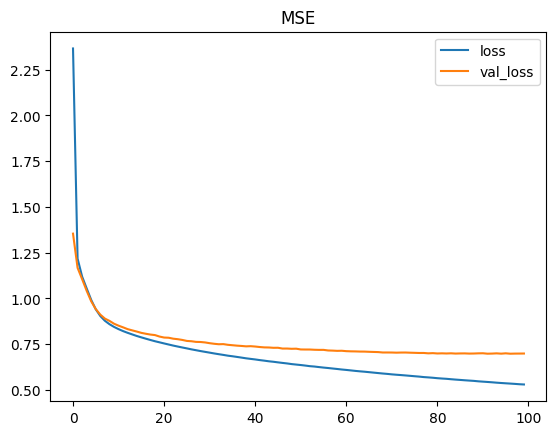

In [26]:
baseline_df = pd.DataFrame(baseline.history)
baseline_df.loc[:, ['loss', 'val_loss']].plot(title="MSE")
print("MSE: {:0.4f}".format(baseline_df['val_loss'].min()))

In [43]:
model.save('../API/model.h5')

In [44]:
# To save tokenizer
tokenizer_json = tokenizer.to_json()
with open('../API/tokenizer.json', 'w') as file:
    file.write(tokenizer_json)

In [45]:
print(model.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 21)]                 0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 22)]                 0         []                            
                                                                                                  
 embedding_1 (Embedding)     multiple                     44900     ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 lstm_2 (LSTM)               [(None, 50),                 20200     ['embedding_1[0][0]']   

## Generate Text

In [41]:
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_embedding_ = embedding(decoder_inputs)
decoder_outputs_, state_h_, state_c_ = decoder_lstm(decoder_embedding_, initial_state=decoder_states_inputs)
decoder_states_ = [state_h_, state_c_]
decoder_outputs_ = decoder_dense(decoder_outputs_)

decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs_] + decoder_states_)

def generate_text(input_sequence):
    states_value = encoder_model.predict(input_sequence)
    target_sequence = np.zeros((1, 1))
    target_sequence[0, 0] = tokenizer.word_index['<start>']
    
    stop_condition = False
    generated_text = []
    
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_sequence] + states_value)
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_word = tokenizer.index_word.get(sampled_token_index, '')
        
        if sampled_word == 'end':
            stop_condition = True
        else:
            generated_text.append(sampled_word)

        target_sequence = np.zeros((1, 1))
        target_sequence[0, 0] = sampled_token_index
        states_value = [h, c]
    
    return ' '.join(generated_text)

In [36]:
# Get user inputs
feature_1 = input("Enter tools: ")
feature_2 = input("Enter a description of you're dream job: ")

Enter tools:  y
Enter a description of you're dream job:  y


In [42]:
# Combine features into input sequence
input_sequence = f"{feature_1} {feature_2}"

# Convert string features to tokenized sequences
input_sequence_sequence = tokenizer.texts_to_sequences([input_sequence])

# Pad the sequence
input_sequence_padded = pad_sequences(np.array(input_sequence_sequence), maxlen=max_sequence_length, padding='post')

# Generate text
generated_text = generate_text(input_sequence_padded)
print(generated_text)

1/1 [==============================] - 0s 20ms/step
data analyst
